# Train model LSTM to recognize voice of people **Base Dataset Mixing Augmented**

In [1]:
from torchaudio import transforms
from IPython.display import Audio
from torch.utils.data import random_split
import torchaudio
from enum import Enum
import pandas as pd
import torch
import torch.nn as nn
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

In [2]:
import sys
sys.path.append('../')

In [3]:
def filter_sample_by_clients_ids(data: pd.DataFrame, max_count: int = 500, min_count: int = 4):
	sample_count = data['client_id'].value_counts()
	clients_ids = [e for e in sample_count[sample_count < max_count][sample_count > min_count].index]
	return data[data['client_id'].isin(clients_ids)]

def concatenation(train_data: pd.DataFrame, anchor: pd.DataFrame, posneg: pd.DataFrame) -> pd.DataFrame:
		data_particle_case = pd.DataFrame(columns=['anchor_client_id', 'anchor_path', 'posneg_client_id', 'posneg_path', 'anchor_source', 'posneg_source'])
		data_particle_case[['anchor_client_id', 'anchor_path', 'anchor_source']] = anchor
		data_particle_case[['posneg_client_id', 'posneg_path', 'posneg_source']] = posneg
		return pd.concat([train_data, data_particle_case], ignore_index=True)

def data_generation_base(data: pd.DataFrame, data_frac: int = 1):
	client_ids = data['client_id'].unique()
	data['source'] = 'original'
	
	res_data = pd.DataFrame(columns=['anchor_client_id', 'anchor_path', 'posneg_client_id', 'posneg_path', 'anchor_source', 'posneg_source'])
	for id in client_ids:
		client_id_sample = data[data['client_id'] == id] 
		no_client_id_sample = data[data['client_id'] != id]

		anchor_original = client_id_sample.sample(frac=data_frac).reset_index(drop=True)
		positive_original = client_id_sample.sample(frac=data_frac).reset_index(drop=True)
		res_data = concatenation(res_data, anchor_original, positive_original)

		anchor_neg_original = client_id_sample.sample(frac=data_frac).reset_index(drop=True)
		negative_generated = no_client_id_sample.sample(frac=data_frac).reset_index(drop=True)
		res_data = concatenation(res_data, anchor_neg_original, negative_generated)
	return res_data

In [4]:
import librosa

from src.columns.base_dataset_column import DatasetColumn
from src.transform.transform import CustomAdjustDurationTransform, ResampleTransform, ToMelSpectrogramTransform
import torch
from torch.utils.data import Dataset

from src.transform.composite_transformation import CompositeTransformation

class UniversalDS(Dataset):
	def __init__(
		self,
		voice_dataset,
		voice_data_path,
		generated_voice_dataset = None,
		generated_voice_data_path = None,
		sample_rate=16000,
		duration=3,
		transform=None
	):
		self.voice_dataset = voice_dataset
		self.generated_voice_dataset = generated_voice_dataset
		self.voice_data_path = str(voice_data_path)
		self.generated_voice_data_path = str(generated_voice_data_path)
		self.duration = duration
		self.sample_rate = sample_rate
		if transform is not None:
			self.transform = transform
		else:
			self.transform = CompositeTransformation(
				[
					ResampleTransform(target_sample_rate=sample_rate),
					CustomAdjustDurationTransform(duration_seconds=duration),
					ToMelSpectrogramTransform(
						sample_rate=sample_rate, n_mels=64, n_fft=512)
				]
			)
		self.mix_dataset()

	def __len__(self):
		return len(self.temp_dataset)

	def _get_sample(self, audio_file):
		audio, sample_rate = librosa.load(audio_file, sr=self.sample_rate)
		sample = self.transform.transform((audio, sample_rate))
		return sample

	def _get_sample_path(self, path):
		return self.voice_data_path + path

	def _get_label(self, anchor_client_id, posneg_client_id, anchor_source, posneg_source):
		label =  anchor_client_id == posneg_client_id
		return torch.tensor(1 if label else 0, dtype=torch.int64)
	
	def mix_dataset(self):
		self.temp_dataset = data_generation_base(self.voice_dataset)
		self.reset_iteration()

	def reset_iteration(self):
		self.iteration_to_mix = len(self.temp_dataset)

	def __getitem__(self, idx):

		anchor_path, posneg_path, anchor_client_id, posneg_client_id, anchor_source, posneg_source = self.temp_dataset.iloc[idx][
			[
				DatasetColumn.ANCHOR_PATH,
				DatasetColumn.POSNEG_PATH,
				DatasetColumn.ANCHOR_ID,
				DatasetColumn.POSNEG_ID,
				DatasetColumn.SOURCE_ANCHOR,
				DatasetColumn.SOURCE_POSNEG,
			]
		].values.tolist()

		anchor_file = self._get_sample_path(anchor_path)
		posneg_file = self._get_sample_path(posneg_path)
		label = self._get_label(anchor_client_id, posneg_client_id, anchor_source, posneg_source)
		anchor_sample = self._get_sample(anchor_file)
		posneg_sample = self._get_sample(posneg_file)
		self.iteration_to_mix -= 1
		if self.iteration_to_mix == 0:
			self.mix_dataset()
		return anchor_sample, posneg_sample, label

In [5]:
DATASET_PATH = '../dataset/'
DATA_PATH = '../data/'
MODEL_SAVE_PATH = '../model_save/'
BATCH_SIZE = 24
SAMPLE_RATE = 16000

In [6]:
from src.transform.transform import CustomAdjustDurationTransform, ResampleTransform, CustomAdjustDurationTransform, ShiftWrapperTransform, AirAbsorptionWrapperTransform, EqualizerWrapperTransform, AudioToTimeSeriesTransform
from src.transform.composite_transformation import CompositeTransformation

train_transform = CompositeTransformation(
	[
		ResampleTransform(target_sample_rate=SAMPLE_RATE),
		CustomAdjustDurationTransform(duration_seconds=3),
		ShiftWrapperTransform(min_shift=-0.2, max_shift=0.2),
    AirAbsorptionWrapperTransform(),
    EqualizerWrapperTransform(),
		AudioToTimeSeriesTransform( n_fft=128, hop_len=256)
	]
)

test_transform = CompositeTransformation(
	[
		ResampleTransform(target_sample_rate=SAMPLE_RATE),
		CustomAdjustDurationTransform(duration_seconds=3),
    AirAbsorptionWrapperTransform(),
    EqualizerWrapperTransform(),
		AudioToTimeSeriesTransform( n_fft=128, hop_len=256)
	]
)

In [7]:
voice_df = pd.read_csv(DATA_PATH + "validated.tsv",  sep='\t')
voice_df = filter_sample_by_clients_ids(voice_df, min_count=3)[['client_id', 'path']]
train_ds = UniversalDS(voice_df, DATA_PATH + "validated_16000/", transform=train_transform)

In [8]:
from src.dataset.base_dataset import BaseSoundDS


test_df = pd.read_csv(DATASET_PATH + "test_base_dataset.csv")
test_ds = BaseSoundDS(test_df, DATA_PATH + "validated_16000/", transform=test_transform)

In [9]:
test_ds[11][0].shape

torch.Size([188, 65])

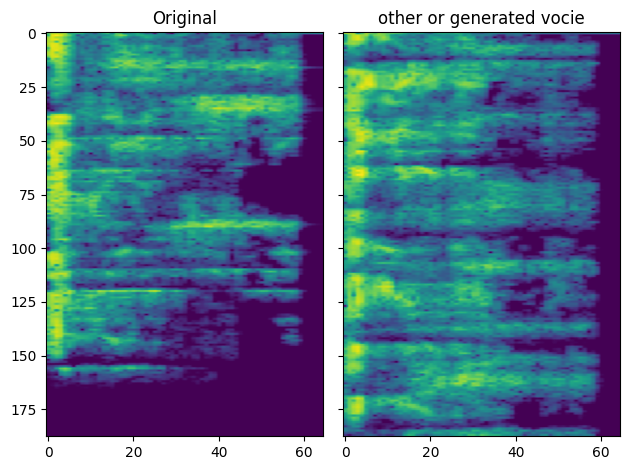

In [10]:
import matplotlib.pyplot as plt
def plot_lstm(sample):
	def plot_spec(ax, spec, title):
		ax.set_title(title)
		ax.imshow(spec, origin="lower", aspect="auto")
		ax.invert_yaxis()
	fig, axes = plt.subplots(1, 2, sharex=True, sharey=True)
	posneg = "same voice"
	if not sample[2]:
		posneg = "other or generated vocie"
	plot_spec(axes[0], sample[0], title="Original")
	plot_spec(axes[1], sample[1], title=posneg)
	fig.tight_layout()

plot_lstm(test_ds[11])
train_ds.reset_iteration()

In [11]:
class SiameseNetwork(nn.Module):
	def __init__(self, input_size, hidden_size, num_layers):
		super(SiameseNetwork, self).__init__()
		self.hidden_size = hidden_size
		self.num_layers = num_layers
		self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, bidirectional = True)
		self.fc = nn.Linear(hidden_size, 512)

		self.final = nn.Linear(512, 2)

	def forward_once(self, x):
		output, _ = self.lstm(x)
		output = self.fc(output[:, -1, :])
		return output

	def forward(self, input1, input2):
		output1 = self.forward_once(input1)
		output2 = self.forward_once(input2)
		return self.final(torch.abs(output1 - output2))

In [12]:
from src.columns.combined_dataset_column import CombinedDatasetColumn
import librosa

from src.columns.generated_dataset_column import GeneratedDatasetColumn
from src.transform.transform import CustomAdjustDurationTransform, ResampleTransform, ToMelSpectrogramTransform, AudioToTimeSeriesTransform
import torch
from torch.utils.data import Dataset

from src.transform.composite_transformation import CompositeTransformation


class CombinedLSTMSoundDS(Dataset):
    def __init__(
        self,
        voiceDataset,
        original_voice_data_path,
        generated_voice_data_path,
        sample_rate=16000,
        duration=3,
        transform=None
    ):
        self.voiceDataset = voiceDataset
        self.original_voice_data_path = str(original_voice_data_path)
        self.generated_voice_data_path = str(generated_voice_data_path)
        self.duration = duration
        self.sample_rate = sample_rate
        self.transform = None
        if transform is not None:
            self.transform = transform
        else:
            self.transform = CompositeTransformation(
                [
                    ResampleTransform(target_sample_rate=sample_rate),
                    CustomAdjustDurationTransform(duration_seconds=duration),
					AudioToTimeSeriesTransform( n_fft=256)
                ]
            )

    def __len__(self):
        return len(self.voiceDataset)

    def _get_sgram(self, audio_file):
        audio, sample_rate = librosa.load(audio_file, sr=self.sample_rate)
        spectrogram = self.transform.transform((audio, sample_rate))
        return spectrogram

    def _get_label(self, anchor_client_id, posneg_client_id, anchor_source, posneg_source):
        label = anchor_client_id == posneg_client_id and anchor_source == posneg_source
        return torch.tensor(1 if label else 0, dtype=torch.int64)

    def _get_sample_path(self, path, source):
        data_path = self.original_voice_data_path if source == 'original' else self.generated_voice_data_path
        return data_path + path

    def __getitem__(self, idx):
        anchor_path, posneg_path, anchor_client_id, posneg_client_id, anchor_source, posneg_source = self.voiceDataset.iloc[idx][
            [
                CombinedDatasetColumn.ANCHOR_PATH,
                CombinedDatasetColumn.POSNEG_PATH,
                CombinedDatasetColumn.ANCHOR_ID,
                CombinedDatasetColumn.POSNEG_ID,
                CombinedDatasetColumn.SOURCE_ANCHOR,
                CombinedDatasetColumn.SOURCE_POSNEG
            ]
        ].values.tolist()

        anchor_file = self._get_sample_path(anchor_path, anchor_source)
        posneg_file = self._get_sample_path(posneg_path, posneg_source)
        label = self._get_label(
            anchor_client_id, posneg_client_id, anchor_source, posneg_source)
        anchor_sgram = self._get_sgram(anchor_file)
        posneg_sgram = self._get_sgram(posneg_file)

        return anchor_sgram, posneg_sgram, label

In [13]:
test_df = pd.read_csv(DATASET_PATH + "test_base_dataset.csv")
test_ds = CombinedLSTMSoundDS(test_df, original_voice_data_path=DATA_PATH + "validated_16000/", generated_voice_data_path=DATA_PATH + "generated_16000/", transform=test_transform)

In [14]:
train_dl = torch.utils.data.DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
test_dl = torch.utils.data.DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=True)

In [15]:
def save_model(model, model_name, base_path = './model_save/'):
  model.cpu()
  model.eval()
  torch.save(model, base_path + model_name)

In [16]:
class CrossEntropyLoss(torch.nn.Module):
	def __init__(self):
		super(CrossEntropyLoss, self).__init__()

	def forward(self, output, label):
		label = label.long()
		loss = F.cross_entropy(output, label)
		return loss

In [17]:
class SiameseNetwork(nn.Module):
	def __init__(self, input_size, hidden_size, num_layers):
		super(SiameseNetwork, self).__init__()
		self.hidden_size = hidden_size
		self.num_layers = num_layers
		self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
		self.fc = nn.Linear(hidden_size, 512)

		self.final = nn.Linear(512, 2)

	def forward_once(self, x):
		output, _ = self.lstm(x)
		output = self.fc(output[:, -1, :])
		return output

	def forward(self, input1, input2):
		output1 = self.forward_once(input1)
		output2 = self.forward_once(input2)
		return self.final(torch.abs(output1 - output2))

In [18]:
num_epochs = 10
siamese_model = SiameseNetwork(input_size=train_ds[0][0].shape[-1], hidden_size=1024, num_layers=1).to('cuda')
criterion = CrossEntropyLoss().to('cuda')
optimizer = optim.Adam(siamese_model.parameters(), lr=0.0001)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [19]:
import copy
from src.trainer.siamese_trainer import evaluate_siamese_model, train_siamese_model

loss, accuracy, precision, recall, f1 = [], [], [], [], []
best_accuracy=0
for epoch in range(num_epochs):
	_train_loss, _train_accuracy, _train_precision, _train_recall, _train_f1 = train_siamese_model(siamese_model, train_dl, criterion, optimizer, device)
	print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {_train_loss:.4f}, "f"Accuracy: {_train_accuracy:.4f}, Precision: {_train_precision:.4f}, Recall: {_train_recall:.4f}, F1: {_train_f1:.4f}")
	_test_loss, _test_accuracy, _test_precision, _test_recall, _test_f1 = evaluate_siamese_model(siamese_model, test_dl, criterion, device)
	print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {_test_loss:.4f}, "f"Accuracy: {_test_accuracy:.4f}, Precision: {_test_precision:.4f}, Recall: {_test_recall:.4f}, F1: {_test_f1:.4f}")
	if _test_accuracy > best_accuracy:
		best_accuracy = _test_accuracy
		best_model = copy.deepcopy(siamese_model)
	loss.append([_train_loss, _test_loss])
	accuracy.append([_train_accuracy, _test_accuracy])
	precision.append([_train_precision, _test_precision])
	recall.append([_train_recall, _test_recall])
	f1.append([_train_f1, _test_f1])


Epoch 1/10, Loss: 0.6882, Accuracy: 0.5298, Precision: 0.5395, Recall: 0.4070, F1: 0.4640


Epoch 1/10, Loss: 0.6791, Accuracy: 0.5373, Precision: 0.5682, Recall: 0.3112, F1: 0.4021


Epoch 2/10, Loss: 0.6584, Accuracy: 0.5968, Precision: 0.6373, Recall: 0.4492, F1: 0.5270


Epoch 2/10, Loss: 0.6594, Accuracy: 0.6100, Precision: 0.6688, Recall: 0.4357, F1: 0.5276


Epoch 3/10, Loss: 0.6178, Accuracy: 0.6554, Precision: 0.6841, Recall: 0.5774, F1: 0.6262


Epoch 3/10, Loss: 0.6325, Accuracy: 0.6266, Precision: 0.6276, Recall: 0.6224, F1: 0.6250


Epoch 4/10, Loss: 0.5851, Accuracy: 0.6871, Precision: 0.7125, Recall: 0.6275, F1: 0.6673


Epoch 4/10, Loss: 0.6278, Accuracy: 0.6515, Precision: 0.6714, Recall: 0.5934, F1: 0.6300


Epoch 5/10, Loss: 0.5525, Accuracy: 0.7271, Precision: 0.7405, Recall: 0.6992, F1: 0.7193


Epoch 5/10, Loss: 0.6311, Accuracy: 0.6660, Precision: 0.6695, Recall: 0.6556, F1: 0.6625


Epoch 6/10, Loss: 0.5378, Accuracy: 0.7344, Precision: 0.7502, Recall: 0.7028, F1: 0.7257


Epoch 6/10, Loss: 0.6107, Accuracy: 0.6515, Precision: 0.6540, Recall: 0.6432, F1: 0.6485


Epoch 7/10, Loss: 0.5194, Accuracy: 0.7463, Precision: 0.7558, Recall: 0.7276, F1: 0.7415


Epoch 7/10, Loss: 0.6067, Accuracy: 0.6639, Precision: 0.6491, Recall: 0.7137, F1: 0.6798


Epoch 8/10, Loss: 0.4938, Accuracy: 0.7615, Precision: 0.7681, Recall: 0.7493, F1: 0.7586


Epoch 8/10, Loss: 0.5915, Accuracy: 0.6680, Precision: 0.6667, Recall: 0.6722, F1: 0.6694


Epoch 9/10, Loss: 0.4974, Accuracy: 0.7560, Precision: 0.7610, Recall: 0.7464, F1: 0.7537


Epoch 9/10, Loss: 0.6002, Accuracy: 0.6369, Precision: 0.6231, Recall: 0.6929, F1: 0.6562


Epoch 10/10, Loss: 0.4876, Accuracy: 0.7717, Precision: 0.7692, Recall: 0.7763, F1: 0.7727


Epoch 10/10, Loss: 0.5916, Accuracy: 0.6867, Precision: 0.6786, Recall: 0.7095, F1: 0.6937


In [20]:
import matplotlib.pyplot as plt

def plot_metrix(loss, accuracy):
	epochs = range(1, len(loss) + 1)

	fig, axs = plt.subplots(2, 1, figsize=(12, 8))
	fig.suptitle("Model Metrics")


	axs[0].plot(epochs, [e[0] for e in loss], label=" Train loss", color="g")
	axs[0].plot(epochs, [e[1] for e in loss], label="Test loss", color="b")
	axs[0].set_title("Loss")
	axs[0].set_xlabel("Epoch")
	axs[0].set_ylabel("Loss")

	axs[1].plot(epochs, [e[0] for e in accuracy], label="Train accuracy", color="g")
	axs[1].plot(epochs, [e[1] for e in accuracy], label="Test accuracy", color="b")
	axs[1].set_title("Accuracy")
	axs[1].set_xlabel("Epoch")
	axs[1].set_ylabel("Accuracy")

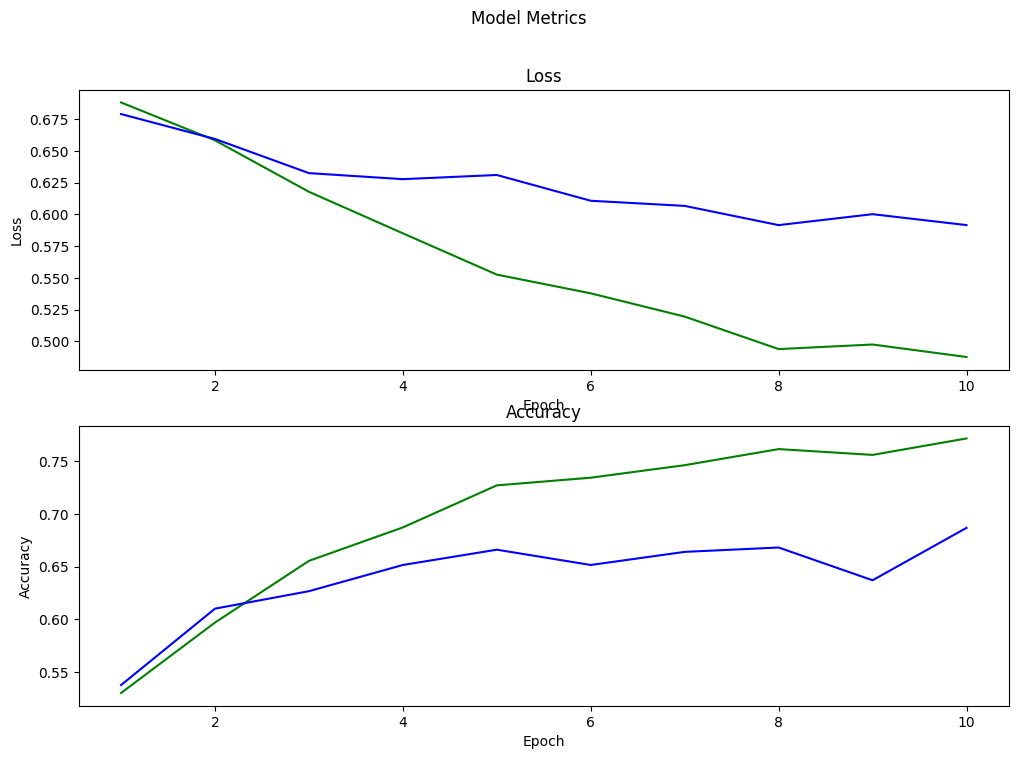

In [21]:
plot_metrix(loss, accuracy)

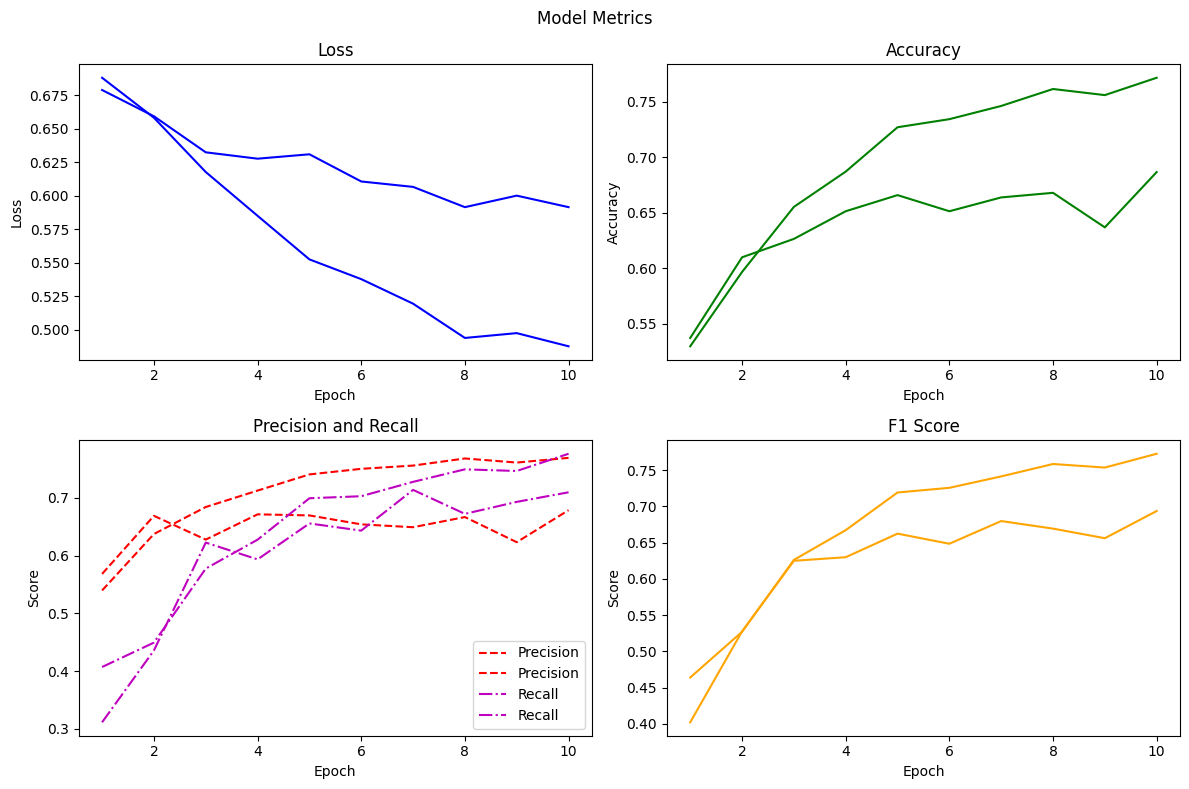

In [22]:
import matplotlib.pyplot as plt

epochs = range(1, len(loss) + 1)  


fig, axs = plt.subplots(2, 2, figsize=(12, 8))
fig.suptitle("Model Metrics")


axs[0, 0].plot(epochs, loss, label="Loss", color="b")
axs[0, 0].set_title("Loss")
axs[0, 0].set_xlabel("Epoch")
axs[0, 0].set_ylabel("Loss")

axs[0, 1].plot(epochs, accuracy, label="Accuracy", color="g")
axs[0, 1].set_title("Accuracy")
axs[0, 1].set_xlabel("Epoch")
axs[0, 1].set_ylabel("Accuracy")


axs[1, 0].plot(epochs, precision, label="Precision", color="r", linestyle="--")
axs[1, 0].plot(epochs, recall, label="Recall", color="m", linestyle="-.")
axs[1, 0].set_title("Precision and Recall")
axs[1, 0].set_xlabel("Epoch")
axs[1, 0].set_ylabel("Score")
axs[1, 0].legend()


axs[1, 1].plot(epochs, f1, label="F1 Score", color="orange")
axs[1, 1].set_title("F1 Score")
axs[1, 1].set_xlabel("Epoch")
axs[1, 1].set_ylabel("Score")

plt.tight_layout()
plt.show()

In [23]:
torch.save(siamese_model.to('cpu'), 'my_lstm_b_model.pt')

In [24]:
import matplotlib.pyplot as plt
def explain_model(model: torch.nn.Module, anchor_sgram: torch.tensor, posneg_sgram: torch.tensor, mode: str = "PREDICTED"):
	allowed_mode = ["GENERATED_CLASS, ORIGIN_CLASS", "PREDICTED"]
	if mode not in allowed_mode:
		raise ValueError()
	model.eval()
	model.cpu()
	anchor_sgram = torch.clone(anchor_sgram)
	posneg_sgram = torch.clone(posneg_sgram)

	anchor_sgram.unsqueeze_(0)
	posneg_sgram.unsqueeze_(0)
	anchor_sgram.requires_grad = True
	posneg_sgram.requires_grad = True

	anchor_sgram = anchor_sgram
	posneg_sgram = posneg_sgram

	predictions = model(anchor_sgram, posneg_sgram)
	if mode == "PREDICTED":
		class_id = predictions[0].argmax()
	if mode == "GENERATED_CLASS":
		class_id = 0
	if mode == "ORIGIN_CLASS":
		class_id = 1
	neuron = predictions[0, class_id]

	neuron.retain_grad()
	neuron.backward()
	anchor_slc, _ = torch.max(torch.abs(anchor_sgram.grad), dim=0)
	anchor_grad = (anchor_slc - anchor_slc.min())/(anchor_slc.max()-anchor_slc.min())

	posneg_slc, _ = torch.max(torch.abs(posneg_sgram.grad), dim=0)
	posneg_grad = (posneg_slc - posneg_slc.min())/(posneg_slc.max()-posneg_slc.min())

	return anchor_grad, posneg_grad


In [25]:
def plot_explain_siamese_lstm_model_all(anchor_sgram, posneg_sgram, anchor_sgram_grad, posneg_sgram_grad):
	plt.figure(figsize=(5, 4))

	plt.subplot(1, 2, 1)
	plt.title("Anchor Sgram")
	plt.imshow(anchor_sgram,  origin="lower", aspect="auto")
	plt.subplot(1, 2, 2)
	plt.tight_layout()
	plt.title("Anchor Sgram Grad")
	plt.imshow(anchor_sgram_grad.numpy(), cmap=plt.cm.hot,
			   origin="lower", aspect="auto")
	plt.figure(figsize=(5, 4))
	plt.subplot(1, 2, 1)
	plt.title("PosNeg Sgram")
	plt.imshow(posneg_sgram,  origin="lower", aspect="auto")
	plt.subplot(1, 2, 2)
	plt.tight_layout()
	plt.title("PosNeg Sgram Grad")
	plt.imshow(posneg_sgram_grad.numpy(), cmap=plt.cm.hot,
			   origin="lower", aspect="auto")
	plt.show()

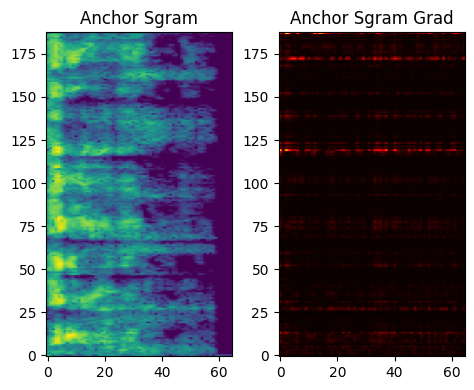

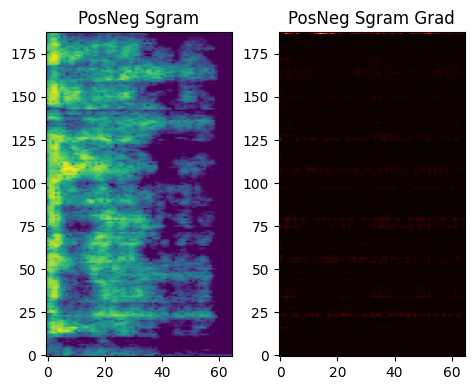

In [26]:
anchor_sgram, posneg_sgram, _ = test_ds[56]
anchor_sgram_grad, posneg_sgram_grad = explain_model(siamese_model.cpu(), anchor_sgram=anchor_sgram, posneg_sgram=posneg_sgram)
plot_explain_siamese_lstm_model_all(anchor_sgram, posneg_sgram, anchor_sgram_grad, posneg_sgram_grad)

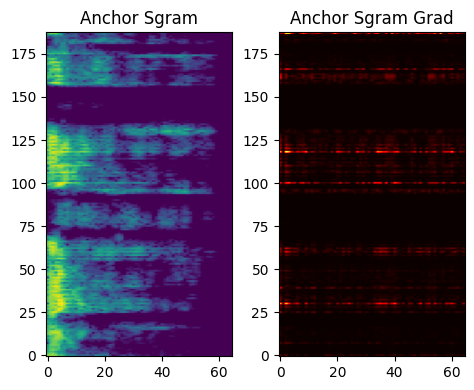

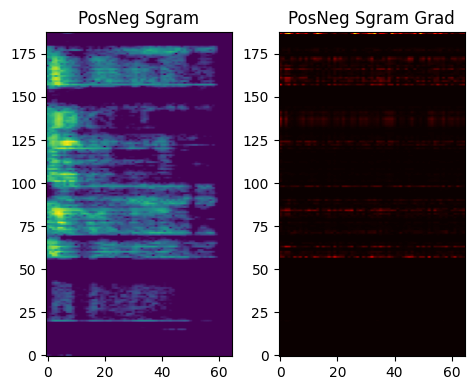

In [27]:
anchor_sgram, posneg_sgram, _ = train_ds[56]
anchor_sgram_grad, posneg_sgram_grad = explain_model(siamese_model.cpu(), anchor_sgram=anchor_sgram, posneg_sgram=posneg_sgram)
plot_explain_siamese_lstm_model_all(anchor_sgram, posneg_sgram, anchor_sgram_grad, posneg_sgram_grad)

In [28]:
def integrated_gradients(model,anchor_sgram, posneg_sgram, baseline=None, num_steps=10):

	if baseline is None:
		anchor_baseline = torch.zeros_like(anchor_sgram)
		posneg_baseline = torch.zeros_like(posneg_sgram)

	anchor_scaled_inputs = [anchor_baseline + (float(i) / num_steps) * (anchor_sgram - anchor_baseline) for i in range(num_steps + 1)]
	posneg_scaled_inputs = [posneg_baseline + (float(i) / num_steps) * (posneg_sgram - posneg_baseline) for i in range(num_steps + 1)]
	anchor_inputs = torch.stack(anchor_scaled_inputs)
	posneg_inputs = torch.stack(posneg_scaled_inputs)
	anchor_inputs.requires_grad = True
	posneg_inputs.requires_grad = True
	model.zero_grad()
	model.eval()
	model.cpu()
	outputs = model(anchor_inputs, posneg_inputs)

	anchor_prob_predicted_class = torch.softmax(outputs, dim=1)[:, torch.argmax(outputs, dim=1)].sum()

	anchor_gradients = torch.autograd.grad(anchor_prob_predicted_class, anchor_inputs)[0]

	outputs = model(anchor_inputs, posneg_inputs)
	posneg_prob_predicted_class = torch.softmax(outputs, dim=1)[:, torch.argmax(outputs, dim=1)].sum()
	posneg_gradients = torch.autograd.grad(posneg_prob_predicted_class, posneg_inputs)[0]
	anchor_integrated_gradients = (anchor_inputs - anchor_baseline) * anchor_gradients.mean(0)
	posneg_integrated_gradients = (posneg_inputs - anchor_baseline) * posneg_gradients.mean(0)
	anchor_integrated_gradients = torch.mean(anchor_integrated_gradients, dim=0)
	posneg_integrated_gradients =torch.mean(posneg_integrated_gradients, dim=0)
	return anchor_integrated_gradients.detach().numpy(), posneg_integrated_gradients.detach().numpy()

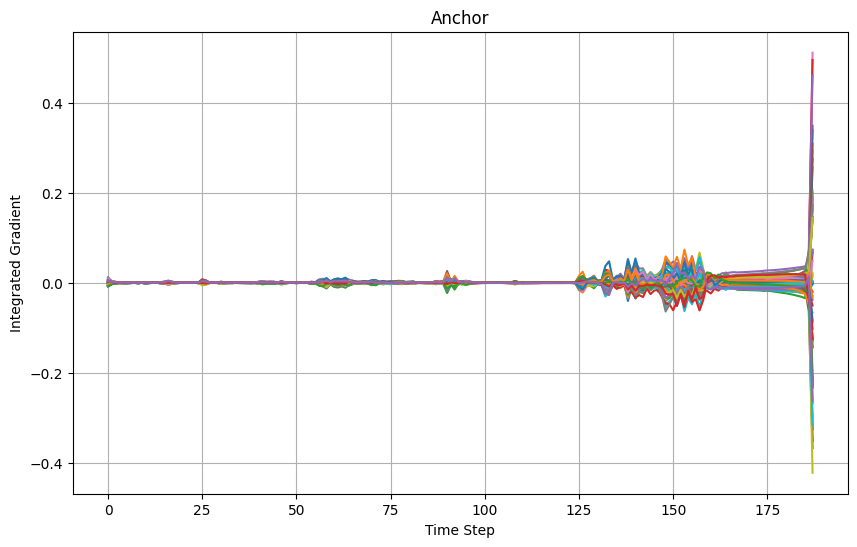

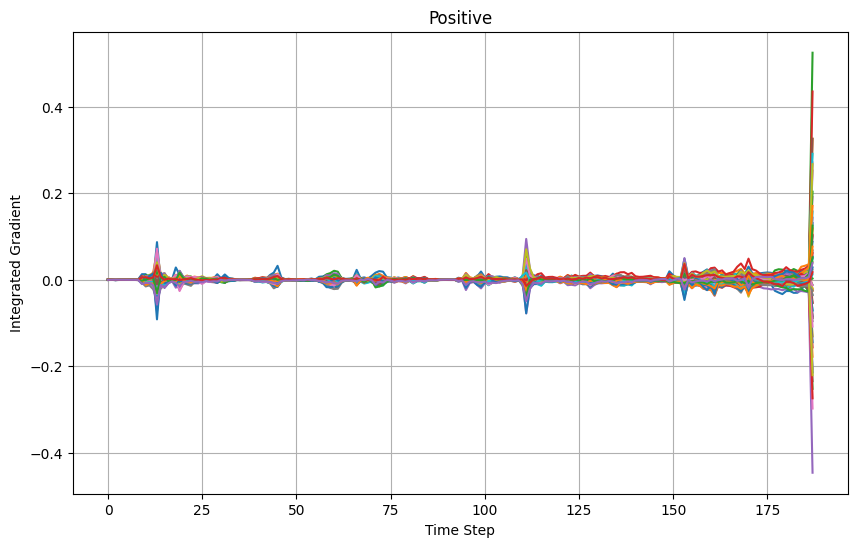

In [29]:
anchor_sgram, posneg_sgram, label = train_ds[56]
anchor_integrated_gradients, posneg_integrated_gradients = integrated_gradients(siamese_model, anchor_sgram, posneg_sgram)
plt.figure(figsize=(10, 6))
for i in range(anchor_integrated_gradients.shape[-1]):
	plt.plot(anchor_integrated_gradients[:, i], label=f"Feature {i}")
plt.xlabel("Time Step")
plt.ylabel("Integrated Gradient")
plt.title("Anchor")
plt.grid(True)
plt.show()
plt.figure(figsize=(10, 6))
for i in range(posneg_integrated_gradients.shape[-1]):
	plt.plot(posneg_integrated_gradients[:, i], label=f"Feature {i}")
plt.xlabel("Time Step")
plt.ylabel("Integrated Gradient")
plt.title("Positive" if label else "Negative")
plt.grid(True)
plt.show()

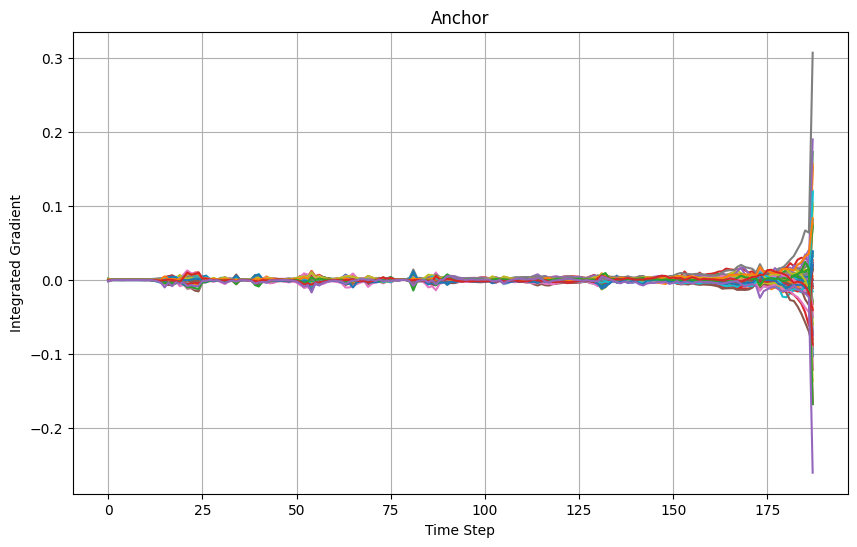

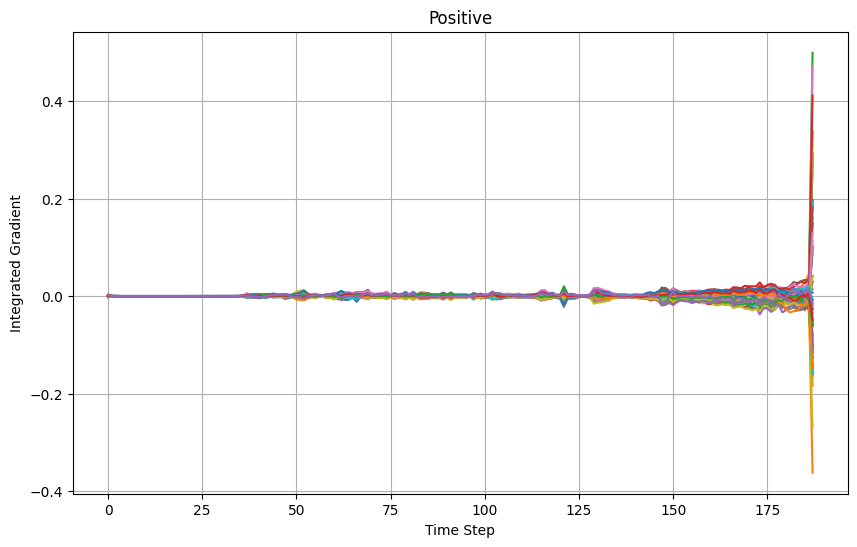

In [30]:
anchor_sgram, posneg_sgram, label = test_ds[56]
anchor_integrated_gradients, posneg_integrated_gradients = integrated_gradients(siamese_model, anchor_sgram, posneg_sgram)
plt.figure(figsize=(10, 6))
for i in range(anchor_integrated_gradients.shape[-1]):
	plt.plot(anchor_integrated_gradients[:, i], label=f"Feature {i}")
plt.xlabel("Time Step")
plt.ylabel("Integrated Gradient")
plt.title("Anchor")
plt.grid(True)
plt.show()
plt.figure(figsize=(10, 6))
for i in range(posneg_integrated_gradients.shape[-1]):
	plt.plot(posneg_integrated_gradients[:, i], label=f"Feature {i}")
plt.xlabel("Time Step")
plt.ylabel("Integrated Gradient")
plt.title("Positive" if label else "Negative")
plt.grid(True)
plt.show()

In [31]:
from tqdm import tqdm
def test(model, dataloader, criterion, device='cpu'):
	model.eval()
	model.to(device)
	total_loss = 0.0
	predictions = []
	true_labels = []

	with torch.no_grad():
		for batch in tqdm(dataloader, desc="Evaluating", leave=False):
			anchor_sgram, posneg_sgram, label = batch
			anchor_sgram = anchor_sgram.to(device)
			posneg_sgram = posneg_sgram.to(device)
			label = label.to(device)
			output = model(anchor_sgram, posneg_sgram)
			loss = criterion(output, label)
			total_loss += loss.item()

			predictions += [torch.argmax(pred).item() for pred in output.cpu()]
			true_labels += [label.item() for label in label.cpu()]


	avg_loss = total_loss / len(dataloader)

	return avg_loss, true_labels, predictions

In [32]:
import matplotlib.pyplot as plt  
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score
def displayConfusionMatrix(true_labels, predictions):
	matrix = confusion_matrix(y_true=true_labels, y_pred= predictions, normalize="true" )
	disp = ConfusionMatrixDisplay(confusion_matrix=matrix,display_labels = ["Negative","Positive"]) 
	disp.plot(cmap=plt.cm.Blues) 
	plt.show()

accuracy: 0.6784232365145229


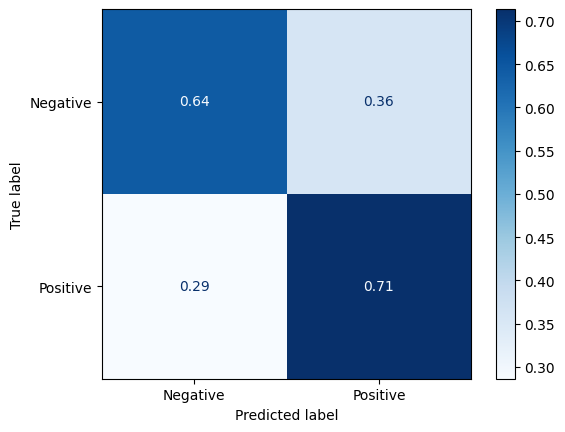

In [33]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score


avg_loss, true_labels, predictions = test(best_model, test_dl, criterion, device)
print(f"accuracy: {accuracy_score(true_labels, predictions)}")
displayConfusionMatrix(true_labels, predictions)

In [34]:
from src.columns.combined_dataset_column import CombinedDatasetColumn
import librosa

from src.columns.generated_dataset_column import GeneratedDatasetColumn
from src.transform.transform import CustomAdjustDurationTransform, ResampleTransform, ToMelSpectrogramTransform, AudioToTimeSeriesTransform
import torch
from torch.utils.data import Dataset

from src.transform.composite_transformation import CompositeTransformation


class CombinedLSTMSoundDS(Dataset):
    def __init__(
        self,
        voiceDataset,
        original_voice_data_path,
        generated_voice_data_path,
        sample_rate=16000,
        duration=3,
        transform=None
    ):
        self.voiceDataset = voiceDataset
        self.original_voice_data_path = str(original_voice_data_path)
        self.generated_voice_data_path = str(generated_voice_data_path)
        self.duration = duration
        self.sample_rate = sample_rate
        self.transform = None
        if transform is not None:
            self.transform = transform
        else:
            self.transform = CompositeTransformation(
                [
                    ResampleTransform(target_sample_rate=sample_rate),
                    CustomAdjustDurationTransform(duration_seconds=duration),
					AudioToTimeSeriesTransform( n_fft=128, hop_len=256)
                ]
            )

    def __len__(self):
        return len(self.voiceDataset)

    def _get_sgram(self, audio_file):
        audio, sample_rate = librosa.load(audio_file, sr=self.sample_rate)
        spectrogram = self.transform.transform((audio, sample_rate))
        return spectrogram

    def _get_label(self, anchor_client_id, posneg_client_id, anchor_source, posneg_source):
        label = anchor_client_id == posneg_client_id and anchor_source == posneg_source
        return torch.tensor(1 if label else 0, dtype=torch.int64)

    def _get_sample_path(self, path, source):
        data_path = self.original_voice_data_path if source == 'original' else self.generated_voice_data_path
        return data_path + path

    def __getitem__(self, idx):
        anchor_path, posneg_path, anchor_client_id, posneg_client_id, anchor_source, posneg_source = self.voiceDataset.iloc[idx][
            [
                CombinedDatasetColumn.ANCHOR_PATH,
                CombinedDatasetColumn.POSNEG_PATH,
                CombinedDatasetColumn.ANCHOR_ID,
                CombinedDatasetColumn.POSNEG_ID,
                CombinedDatasetColumn.SOURCE_ANCHOR,
                CombinedDatasetColumn.SOURCE_POSNEG
            ]
        ].values.tolist()

        anchor_file = self._get_sample_path(anchor_path, anchor_source)
        posneg_file = self._get_sample_path(posneg_path, posneg_source)
        label = self._get_label(
            anchor_client_id, posneg_client_id, anchor_source, posneg_source)
        anchor_sgram = self._get_sgram(anchor_file)
        posneg_sgram = self._get_sgram(posneg_file)

        return anchor_sgram, posneg_sgram, label

In [35]:
from src.dataset.generated_dataset import GeneratedSoundDS

test_df = pd.read_csv(DATASET_PATH + "test_combined_dataset.csv")
test_ds = CombinedLSTMSoundDS(test_df, original_voice_data_path=DATA_PATH + "validated_16000/", generated_voice_data_path=DATA_PATH + "generated_16000/")
test_dl = torch.utils.data.DataLoader(test_ds, batch_size=16, shuffle=False)

Evaluating:   0%|          | 0/136 [00:00<?, ?it/s]

accuracy: 0.6726519337016574


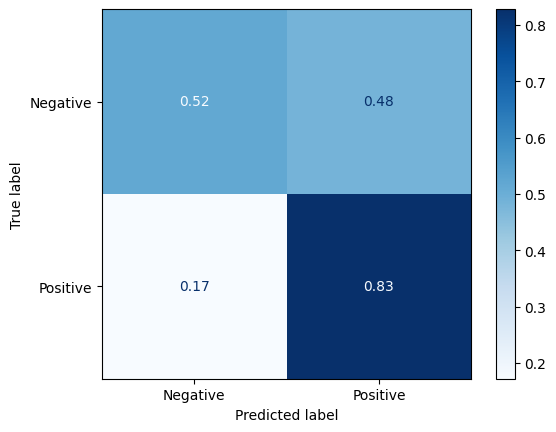

In [36]:
avg_loss, true_labels, predictions = test(siamese_model, test_dl, criterion, device)
print(f"accuracy: {accuracy_score(true_labels, predictions)}")
displayConfusionMatrix(true_labels, predictions)

In [37]:
from src.dataset.generated_dataset import GeneratedSoundDS

test_df = pd.read_csv(DATASET_PATH + "test_generated_dataset_.csv")
test_ds = CombinedLSTMSoundDS(test_df, original_voice_data_path=DATA_PATH + "validated_16000/", generated_voice_data_path=DATA_PATH + "generated_16000/")
test_dl = torch.utils.data.DataLoader(test_ds, batch_size=16, shuffle=False)

accuracy: 0.578838174273859


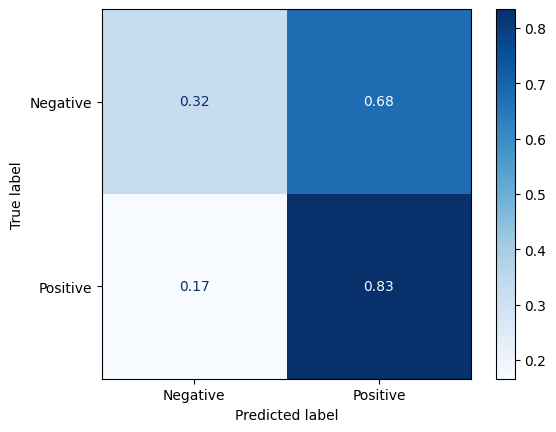

In [38]:
avg_loss, true_labels, predictions = test(siamese_model, test_dl, criterion, device)
print(f"accuracy: {accuracy_score(true_labels, predictions)}")
displayConfusionMatrix(true_labels, predictions)

In [39]:
from src.transform.transform import CustomAdjustDurationTransform, ResampleTransform, CustomAdjustDurationTransform, ShiftWrapperTransform, ToMelSpectrogramTransform, AirAbsorptionWrapperTransform, EqualizerWrapperTransform
from src.transform.composite_transformation import CompositeTransformation

test_transform = CompositeTransformation(
	[
		ResampleTransform(target_sample_rate=SAMPLE_RATE),
		CustomAdjustDurationTransform(duration_seconds=3),
		ShiftWrapperTransform(min_shift=-0.2, max_shift=0.2),
    AirAbsorptionWrapperTransform(),
    EqualizerWrapperTransform(),
		AudioToTimeSeriesTransform( n_fft=128, hop_len=256)
	]
)
test_df = pd.read_csv(DATASET_PATH + "test_base_dataset.csv")
test_ds = CombinedLSTMSoundDS(test_df, DATA_PATH + "validated_16000/",  generated_voice_data_path=None, transform = test_transform)
test_dl = torch.utils.data.DataLoader(test_ds, batch_size=16, shuffle=False)

accuracy: 0.6887966804979253


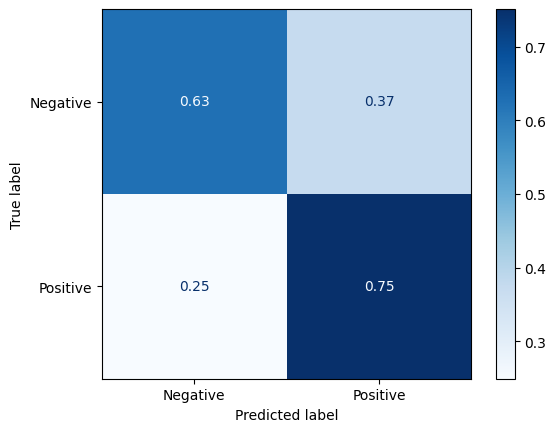

In [40]:
avg_loss, true_labels, predictions = test(siamese_model, test_dl, criterion, device)
print(f"accuracy: {accuracy_score(true_labels, predictions)}")
displayConfusionMatrix(true_labels, predictions)

In [41]:
import matplotlib.pyplot as plt  
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score
def displayConfusionMatrix(true_labels, predictions):
	matrix = confusion_matrix(y_true=true_labels, y_pred= predictions, normalize="true" )
	disp = ConfusionMatrixDisplay(confusion_matrix=matrix,display_labels =  [ "other","same"]) 
	disp.plot(cmap=plt.cm.Blues) 
	plt.show()

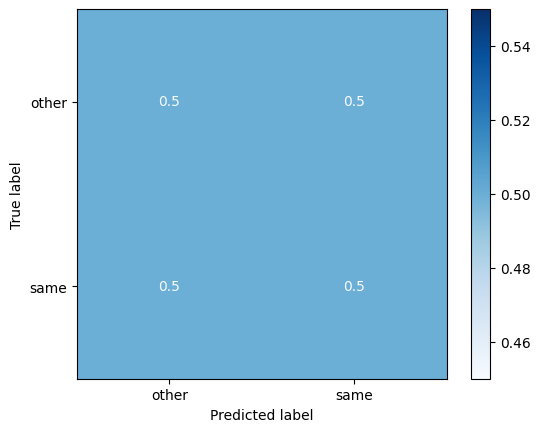

In [42]:
displayConfusionMatrix([1,1,0,0], [1,0,0, 1])